In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Đặt kích thước hiển thị mặc định cho matplotlib
plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
# 1. Đọc ảnh
img = cv2.imread("cat.jpg")  
if img is None:
    raise IOError("Không tìm thấy file ảnh. Hãy kiểm tra lại đường dẫn hoặc tên file!")

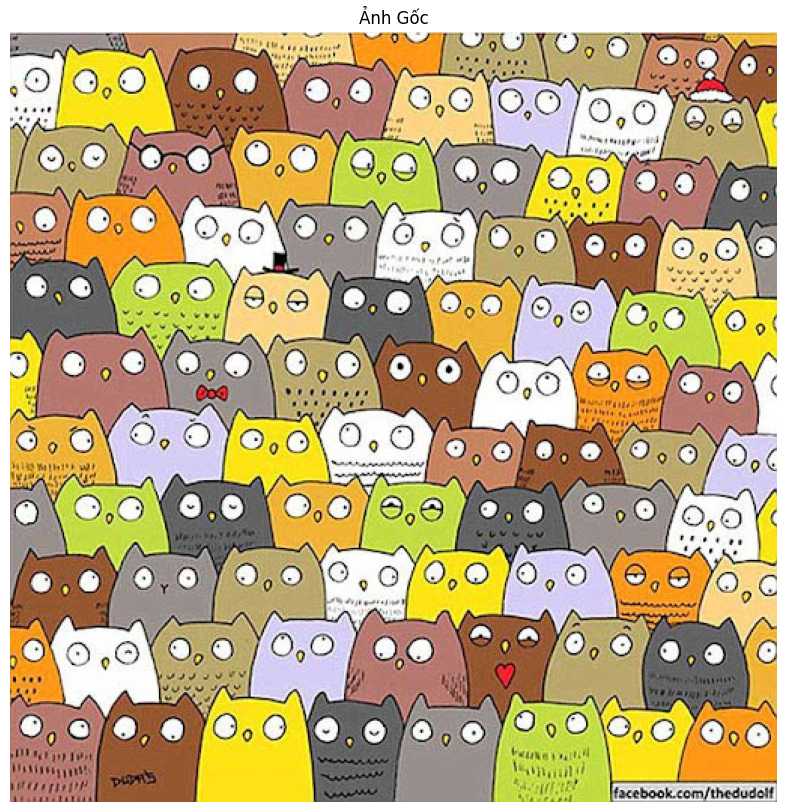

In [3]:
# 2. Hiển thị ảnh gốc
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Ảnh Gốc")
plt.axis("off")
plt.show()

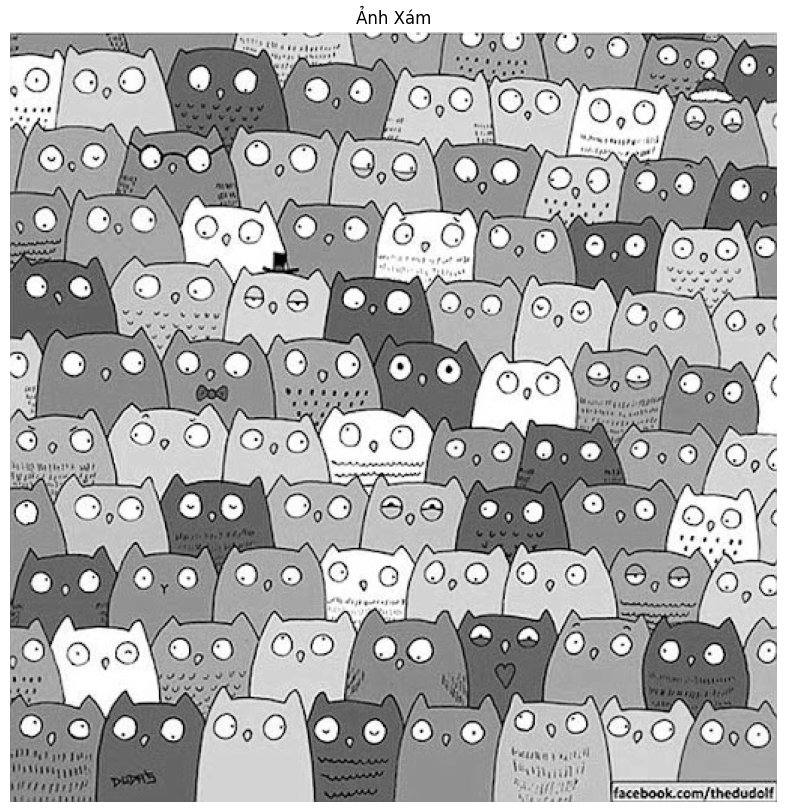

In [4]:
# 3. Chuyển ảnh sang grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")
plt.title("Ảnh Xám")
plt.axis("off")
plt.show()

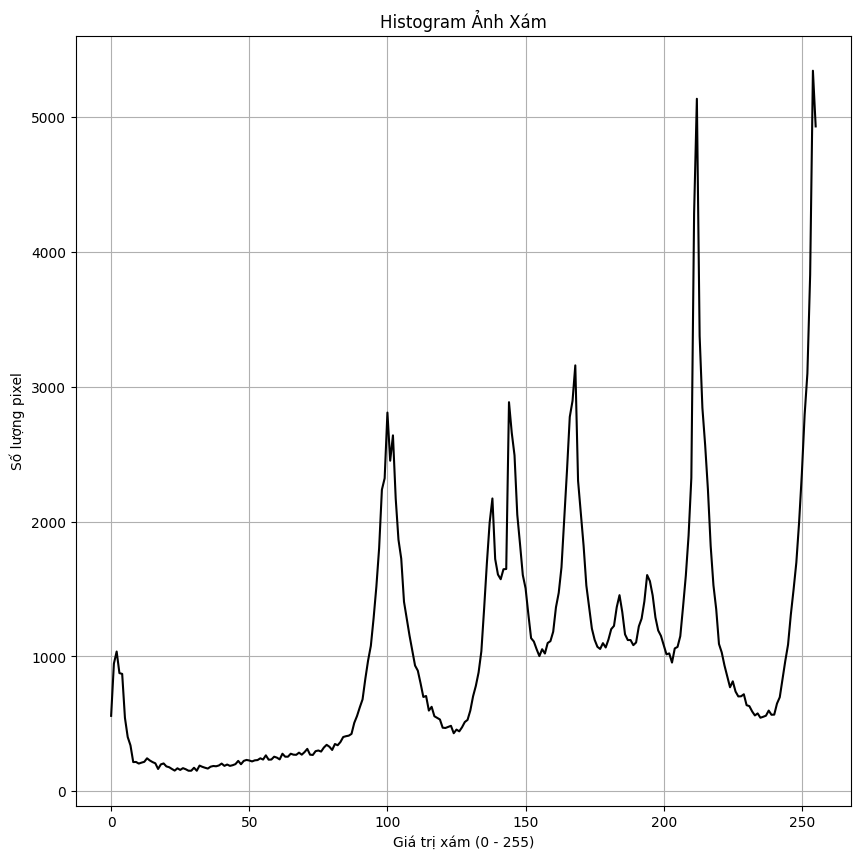

In [5]:
# 4. Vẽ histogram của ảnh xám
histogram = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.plot(histogram, color='black')
plt.title("Histogram Ảnh Xám")
plt.xlabel("Giá trị xám (0 - 255)")
plt.ylabel("Số lượng pixel")
plt.grid(True)
plt.show()

In [6]:
# 5. Hàm lượng tử hoá ảnh xám bằng K-Means
def quantize_gray_image(gray, k):
    # Chuyển ảnh xám thành mảng 2D -> 1D
    img_data = gray.reshape((-1, 1))
    img_data = np.float32(img_data)

    # Thiết lập tiêu chí dừng cho K-Means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        img_data, 
        k, 
        None, 
        criteria, 
        10, 
        cv2.KMEANS_PP_CENTERS
    )
    
    # Chuyển các tâm cụm (centers) về kiểu uint8 và gán lại cho từng pixel
    centers = np.uint8(centers)
    quantized_gray = centers[labels.flatten()]
    quantized_gray = quantized_gray.reshape(gray.shape)

    return quantized_gray

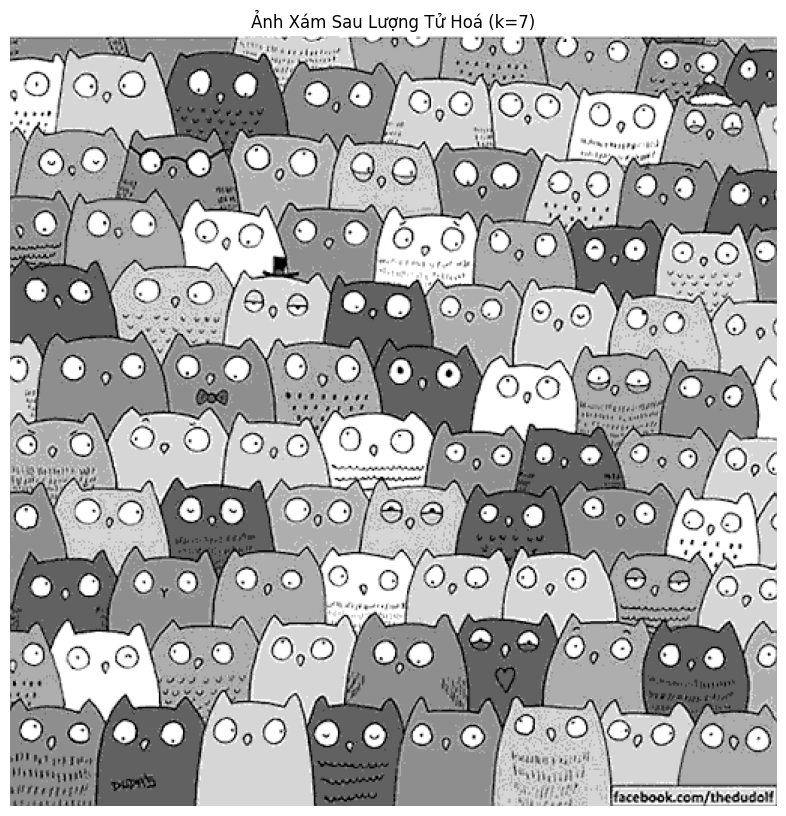

In [7]:
# 6. Lượng tử hoá ảnh xám (k mức)
k = 7  # Thử k = 7 hoặc tuỳ chỉnh
quantized_gray = quantize_gray_image(gray, k)

# Hiển thị ảnh sau lượng tử hoá
plt.imshow(quantized_gray, cmap="gray")
plt.title(f"Ảnh Xám Sau Lượng Tử Hoá (k={k})")
plt.axis("off")
plt.show()

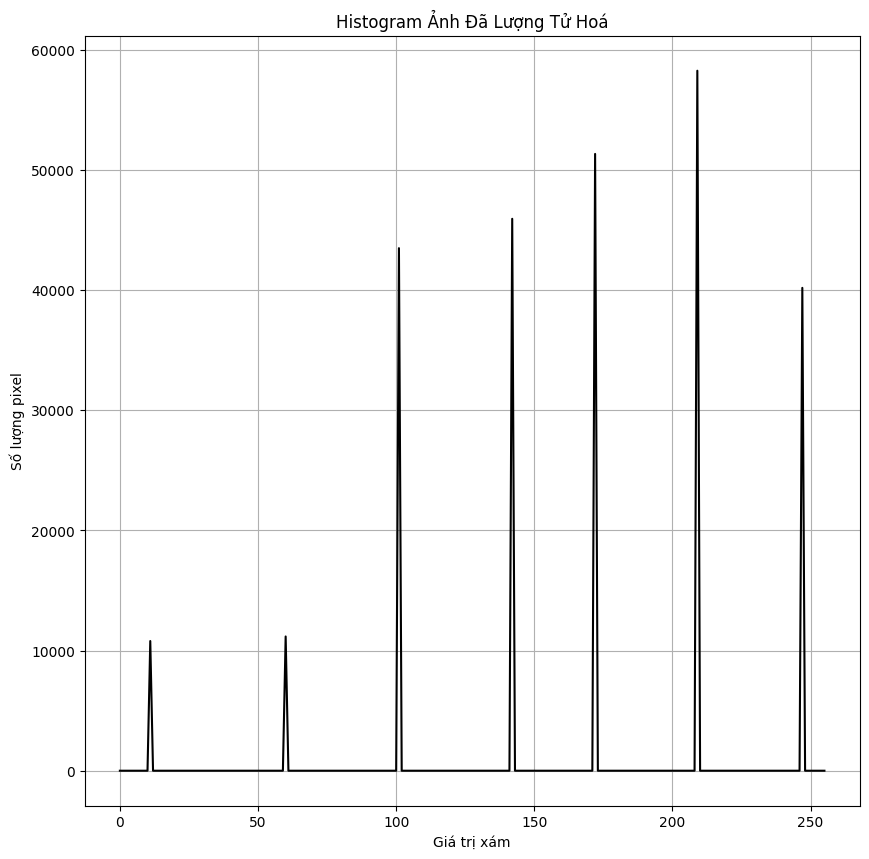

In [8]:
# 7. Tạo histogram cho ảnh sau lượng tử hoá
hist_q = cv2.calcHist([quantized_gray], [0], None, [256], [0, 256])
plt.plot(hist_q, color='black')
plt.title("Histogram Ảnh Đã Lượng Tử Hoá")
plt.xlabel("Giá trị xám")
plt.ylabel("Số lượng pixel")
plt.grid(True)
plt.show()

In [9]:
# 8. Dùng Connected Components để đếm số vật thể
#    Ở đây, ta coi mỗi mức xám là một lớp riêng và tìm các vùng liên thông trong lớp đó.
def count_objects_connected_components(quantized_img, min_size=200):
    """
    Duyệt qua từng mức xám trong ảnh đã lượng tử hoá.
    Tạo mask và tìm thành phần liên thông. 
    Trả về danh sách (level, bounding_box, area).
    """
    unique_values = np.unique(quantized_img)
    objects_info = []
    
    for val in unique_values:
        # Tạo mask cho mức xám val
        mask = (quantized_img == val).astype(np.uint8)

        # Tìm các vùng liên thông kèm thống kê
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            mask, 
            connectivity=8
        )
        
        # stats[i] = [x, y, width, height, area]
        for i in range(1, num_labels):  # bỏ qua i=0 (nền background)
            x, y, w, h, area = stats[i]
            if area >= min_size:
                # Lưu lại thông tin (mức xám, bounding box, diện tích)
                objects_info.append((val, (x, y, w, h), area))
    
    return objects_info

objects_info = count_objects_connected_components(quantized_gray, min_size=200)

# In thử thông tin các vật thể
print(f"Tổng số vùng (>=200 pixel) tìm được: {len(objects_info)}")
for idx, (val, bbox, area) in enumerate(objects_info):
    x, y, w, h = bbox
    print(f"- Object {idx}: Gray Level={val}, Vị trí=({x},{y}), Kích thước={w}x{h}, Diện tích={area}")


Tổng số vùng (>=200 pixel) tìm được: 96
- Object 0: Gray Level=101, Vị trí=(475,8), Kích thước=35x45, Diện tích=896
- Object 1: Gray Level=101, Vị trí=(105,12), Kích thước=79x63, Diện tích=2906
- Object 2: Gray Level=101, Vị trí=(463,88), Kích thước=47x48, Diện tích=1277
- Object 3: Gray Level=101, Vị trí=(370,123), Kích thước=63x56, Diện tích=1863
- Object 4: Gray Level=101, Vị trí=(0,150), Kích thước=71x61, Diện tích=2605
- Object 5: Gray Level=101, Vị trí=(210,163), Kích thước=70x56, Diện tích=2064
- Object 6: Gray Level=101, Vị trí=(243,203), Kích thước=73x61, Diện tích=2363
- Object 7: Gray Level=101, Vị trí=(337,260), Kích thước=71x49, Diện tích=1816
- Object 8: Gray Level=101, Vị trí=(101,296), Kích thước=74x57, Diện tích=2261
- Object 9: Gray Level=101, Vị trí=(297,300), Kích thước=74x52, Diện tích=2062
- Object 10: Gray Level=101, Vị trí=(0,343), Kích thước=70x62, Diện tích=2251
- Object 11: Gray Level=101, Vị trí=(298,387), Kích thước=68x68, Diện tích=2346
- Object 12: Gray L

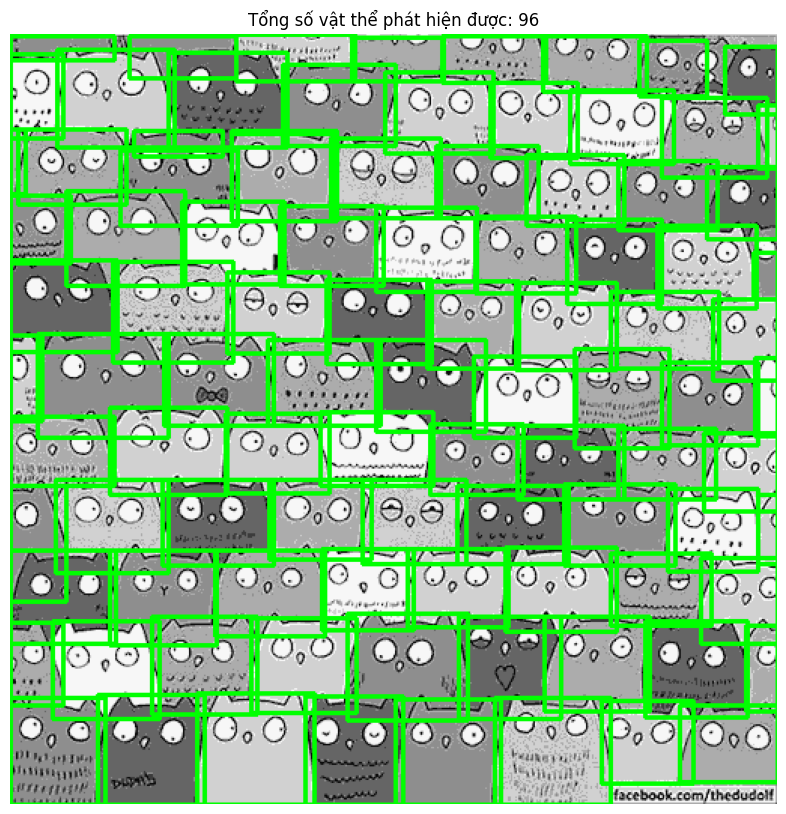

True

In [10]:
# 9. Vẽ bounding box lên ảnh (chuyển ảnh lượng tử hoá sang BGR để dễ vẽ màu)
img_boxes = cv2.cvtColor(quantized_gray, cv2.COLOR_GRAY2BGR)

for _, (x, y, w, h), _ in objects_info:
    cv2.rectangle(img_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Hiển thị ảnh đã vẽ bounding box
plt.imshow(img_boxes[..., ::-1])  # Chuyển BGR -> RGB để hiển thị đúng
plt.title(f"Tổng số vật thể phát hiện được: {len(objects_info)}")
plt.axis("off")
plt.show()

# Tuỳ chọn: Lưu ảnh kết quả
cv2.imwrite("owls_detected.png", img_boxes)
